# PYTORCH GANN


### Source
https://medium.com/@jyotidabass/exploring-gans-a-beginners-guide-with-hands-on-pytorch-implementation-e5b898ead908


### Story
https://www.pivotaltracker.com/story/show/188236366

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get device: cuda, mps or `cpu` on availability
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Operational device is {device.upper()}")

Operational device is CPU


In [3]:
# Generator
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 7 * 7 * 256 ),
            nn.ReLU(True),
            nn.Unflatten(1, (256,7,7)),
            nn.ConvTranspose2d(256,128,5,stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,5,stride=2,padding=2,output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,1,5,stride=2,padding=2,output_padding=1),
            nn.Tanh()            
        )
    def forward(self, x):
        return self.main(x)

In [4]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,5,stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(7 * 7 * 128, 1)
        )
    def forward(self, x):
        return self.main(x)

### Training GAN with MNIST Data

In [5]:
NOISE_DIM = 100

generator = Generator(NOISE_DIM)
discriminator = Discriminator()

In [6]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [7]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

In [8]:
# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas = (0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

In [9]:
# Training of hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 256

In [10]:
# Dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training Loop
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)

        # Train Discriminator with real images
        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1, device=device)
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        # Train Discriminator with fake images
        noise = torch.randn(real_images.size(0), NOISE_DIM, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()
        discriminator_optimizer.step()

        # Train Generator
        generator_optimizer.zero_grad()
        fake_labels = torch.ones(real_images.size(0), 1, device=device)
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, fake_labels)
        gen_loss.backward()
        generator_optimizer.step()

        # Print Losses
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')


Epoch [1/5], Step [1/235], Discriminator Loss: 1.4622, Generator Loss: 1.1164
Epoch [1/5], Step [101/235], Discriminator Loss: 0.2583, Generator Loss: 3.9664
Epoch [1/5], Step [201/235], Discriminator Loss: 0.3174, Generator Loss: 6.0992
Epoch [2/5], Step [1/235], Discriminator Loss: 0.0474, Generator Loss: 4.3595
Epoch [2/5], Step [101/235], Discriminator Loss: 0.0153, Generator Loss: 5.2581
Epoch [2/5], Step [201/235], Discriminator Loss: 0.0275, Generator Loss: 4.9974
Epoch [3/5], Step [1/235], Discriminator Loss: 0.0319, Generator Loss: 5.2115
Epoch [3/5], Step [101/235], Discriminator Loss: 0.0324, Generator Loss: 5.3777
Epoch [3/5], Step [201/235], Discriminator Loss: 0.0142, Generator Loss: 5.4690
Epoch [4/5], Step [1/235], Discriminator Loss: 0.0065, Generator Loss: 5.8478
Epoch [4/5], Step [101/235], Discriminator Loss: 0.0342, Generator Loss: 5.3628
Epoch [4/5], Step [201/235], Discriminator Loss: 0.0120, Generator Loss: 6.0923
Epoch [5/5], Step [1/235], Discriminator Loss: 0

In [16]:
# Generate and save images
def generate_and_save_images(model, epoch, noise):
    model.eval()
    with torch.no_grad():
        fake_images = model(noise).cpu()
        fake_images = fake_images.view(fake_images.size(0), 28, 28)

        fig = plt.figure(figsize=(4, 4))
        for i in range(fake_images.size(0)):
            plt.subplot(4,4, i+1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')

        plt.savefig(f'image_at_epoch_{epoch+1:04d}.png')
        plt.show()

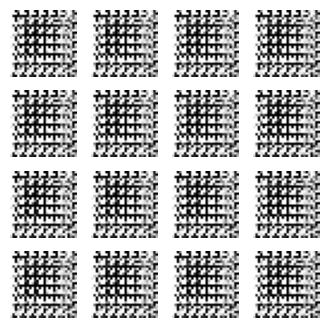

In [18]:
# Generate Test Noise
test_noise = torch.randn(16, NOISE_DIM, device=device)
generate_and_save_images(generator, NUM_EPOCHS, test_noise)